In [1]:
try:
    import google.colab  # noqa: F401

    %pip install -q daml
except Exception:
    pass

import os

from pytest import approx

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tensorflow.nn import relu

from daml.metrics import BER

tf.keras.utils.set_random_seed(408)

In [3]:
# Load in the mnist dataset from tensorflow datasets
(images, labels), (test_images, test_labels) = tfds.mnist.load_data()

In [4]:
print("Number of training samples: ", len(images))
print("Image shape:", images[0].shape)
print("Label counts: ", np.unique(labels, return_counts=True))

Number of training samples:  60000
Image shape: (28, 28)
Label counts:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [5]:
images_split = {}
labels_split = {}

# Keep only 1, 4, and 9
for label in (1, 4, 9):
    subset_indices = np.where(labels == label)
    images_split[label] = images[subset_indices][:2000]
    labels_split[label] = labels[subset_indices][:2000]

images_subset = np.concatenate(list(images_split.values()))
labels_subset = np.concatenate(list(labels_split.values()))
print(images_subset.shape)
print(np.unique(labels_subset, return_counts=True))

(6000, 28, 28)
(array([1, 4, 9], dtype=uint8), array([2000, 2000, 2000]))


In [6]:
# Flatten the images
images_flattened = images_subset.reshape((images_subset.shape[0], -1))
print("Dataset shape:", images_flattened.shape)

Dataset shape: (6000, 784)


In [7]:
# Load the BER metric
metric = BER(images_flattened, labels_subset, method="MST")

In [8]:
# Evaluate the BER metric for the MNIST data with digits 1, 4, 9.
# One minus the value of this metric gives our estimate of the upper bound on accuracy.
base_ber = metric.evaluate()

In [9]:
print("The bayes error rate estimation:", base_ber)

The bayes error rate estimation: {'ber': 0.025833333333333333, 'ber_lower': 0.013044281629080704}


In [10]:
### TEST ASSERTION ###
print(base_ber)
assert base_ber["ber"] == approx(0.025833, abs=1e-6)
assert base_ber["ber_lower"] == approx(0.0130443, abs=1e-6)

{'ber': 0.025833333333333333, 'ber_lower': 0.013044281629080704}


In [11]:
print("The maximum achievable accuracy:", (1 - base_ber["ber"]) * 100)

The maximum achievable accuracy: 97.41666666666666


In [12]:
# Creates a binary mask where current label == 1 that can be used as the new labels
labels_merged = labels_subset == 1
print("New label counts:", np.unique(labels_merged, return_counts=True))

# Update the metric with merged labels with digits 1, and not 1 (classes 4 & 9).
metric.labels = labels_merged

New label counts: (array([False,  True]), array([4000, 2000]))


In [13]:
# Evaluate the BER metric for the MNIST data with updated labels
new_ber = metric.evaluate()

In [14]:
print("The bayes error rate estimation:", new_ber)

The bayes error rate estimation: {'ber': 0.005, 'ber_lower': 0.0025062814466900174}


In [15]:
### TEST ASSERTION ###
print(new_ber)
assert new_ber["ber"] == approx(0.005, abs=1e-6)
assert new_ber["ber_lower"] == approx(0.002506, abs=1e-6)

{'ber': 0.005, 'ber_lower': 0.0025062814466900174}


In [16]:
print("The maximum achievable accuracy:", 1 - new_ber["ber"])

The maximum achievable accuracy: 0.995


In [17]:
# Build a simple CNN for classifying MNIST images.
model = Sequential(
    [
        InputLayer(input_shape=(28, 28, 1)),
        Conv2D(
            64,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Conv2D(
            128,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Conv2D(
            512,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Flatten(),
        Dense(2),
    ]
)

In [18]:
test_indices = np.where((test_labels == 1) | (test_labels == 4) | (test_labels == 9))
test_images_subset = test_images[test_indices]
test_labels_subset = test_labels[test_indices]
test_labels_merged = test_labels_subset == 1

In [19]:
# Set up model hyperparameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Fitting a model may take a few minutes
history = model.fit(
    images_subset,
    labels_merged,
    epochs=90,
    batch_size=32,
    steps_per_epoch=1,
    validation_data=(test_images_subset, test_labels_merged),
    verbose=0,
)

In [20]:
loss, accuracy = model.evaluate(test_images_subset, test_labels_merged, verbose=1)
print(f"The model accuracy: {accuracy*100:0.2f}%")

 1/98 [..............................] - ETA: 3s - loss: 0.0157 - accuracy: 1.0000

 8/98 [=>............................] - ETA: 0s - loss: 0.0500 - accuracy: 0.9844

16/98 [===>..........................] - ETA: 0s - loss: 0.0392 - accuracy: 0.9863

23/98 [======>.......................] - ETA: 0s - loss: 0.0481 - accuracy: 0.9851

30/98 [========>.....................] - ETA: 0s - loss: 0.0480 - accuracy: 0.9844

38/98 [==========>...................] - ETA: 0s - loss: 0.0426 - accuracy: 0.9852

46/98 [=============>................] - ETA: 0s - loss: 0.0404 - accuracy: 0.9864

54/98 [===============>..............] - ETA: 0s - loss: 0.0385 - accuracy: 0.9878

61/98 [=================>............] - ETA: 0s - loss: 0.0364 - accuracy: 0.9887

70/98 [====================>.........] - ETA: 0s - loss: 0.0363 - accuracy: 0.9893

78/98 [======================>.......] - ETA: 0s - loss: 0.0333 - accuracy: 0.9904

86/98 [=========================>....] - ETA: 0s - loss: 0.0309 - accuracy: 0.9909

92/98 [===========================>..] - ETA: 0s - loss: 0.0292 - accuracy: 0.9915

98/98 [==============================] - 1s 7ms/step - loss: 0.0295 - accuracy: 0.9914


The model accuracy: 99.14%


In [21]:
### TEST ASSERTION ###
print(accuracy)
assert accuracy == approx(0.9914, abs=1e-4)

0.9913627505302429


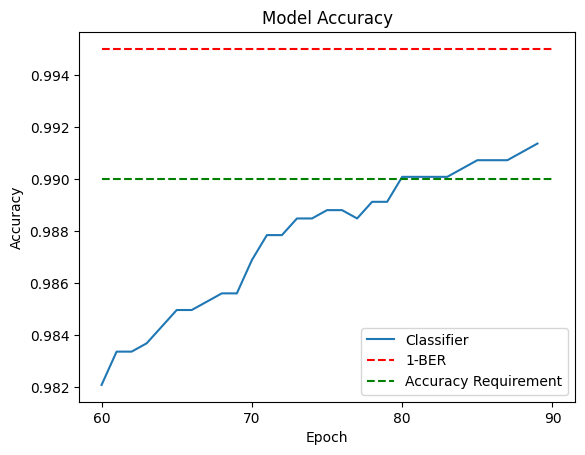

In [22]:
plt.title("Model Accuracy")
plt.plot(range(60, 90), np.array(history.history["val_accuracy"])[60:], label="Classifier")
plt.hlines(
    y=1 - new_ber["ber"],
    colors=["red"],
    xmin=60,
    xmax=90,
    label="1-BER",
    linestyles="dashed",
)
plt.hlines(
    y=0.99,
    colors=["green"],
    xmin=60,
    xmax=90,
    label="Accuracy Requirement",
    linestyles="dashed",
)

plt.xticks(range(60, 91, 10))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc=4)